# Identifying Entities in Healthcare Data

### Workspace set up: Import and Install useful packages.

In [3]:
# installed these 3 as it missed from local PC

#!pip install pycrf
#!pip install sklearn-crfsuite
#!pip install spacy

In [4]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")

In [5]:
import pandas as pd
import numpy as np
from IPython.display import display


## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**


In [7]:
def load_n_preprocess(file_name):
    opened = open(file_name, 'r')
    loaded = opened.readlines()
    opened.close()
    
    all_sentence = []
    sentence = ""

    for word in loaded:
        word = word.strip() # remove space
        if word == "":
            all_sentence.append(sentence)
            sentence = ""
        else:
            if sentence:
                sentence = sentence + " " + word
            else:
                sentence = word
                
    return all_sentence

### Construct the proper sentences from individual words and print the 5 sentences.

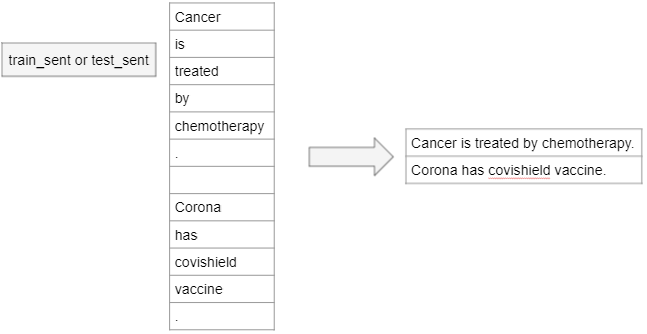

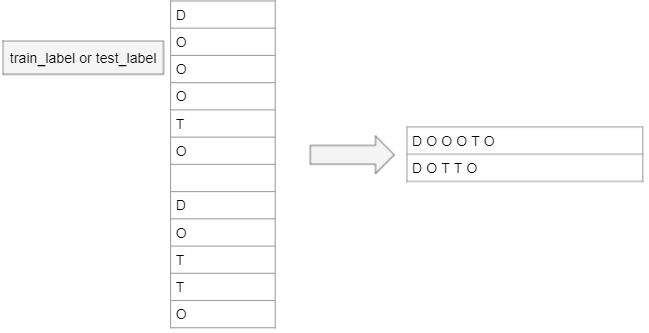

In [10]:
train_sent = load_n_preprocess('data-upgrad/train_sent')
train_label = load_n_preprocess('data-upgrad/train_label')
test_sent = load_n_preprocess('data-upgrad/test_sent')
test_label = load_n_preprocess('data-upgrad/test_label')

In [11]:
def print_sent(sents, label, count=5):
    for i in range(count):
        print("Sentence", i, ":", sents[i])
        
        display(pd.DataFrame([sents[i].split(), label[i].split()], columns = np.arange(len(sents[i].split())), index = ["sentences", "label"]))

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

In [13]:
opened = open("data-upgrad/train_label", 'r')
loaded = opened.readlines()
opened.close()

/var/folders/3j/f10n0hw96xdf7lpsb61w6vn80000gn/T/ipykernel_71510/509549843.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='DTO', data=df, palette='coolwarm')  #Use y='DTO' for vertical bars
/var/folders/3j/f10n0hw96xdf7lpsb61w6vn80000gn/T/ipykernel_71510/509549843.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha="center")


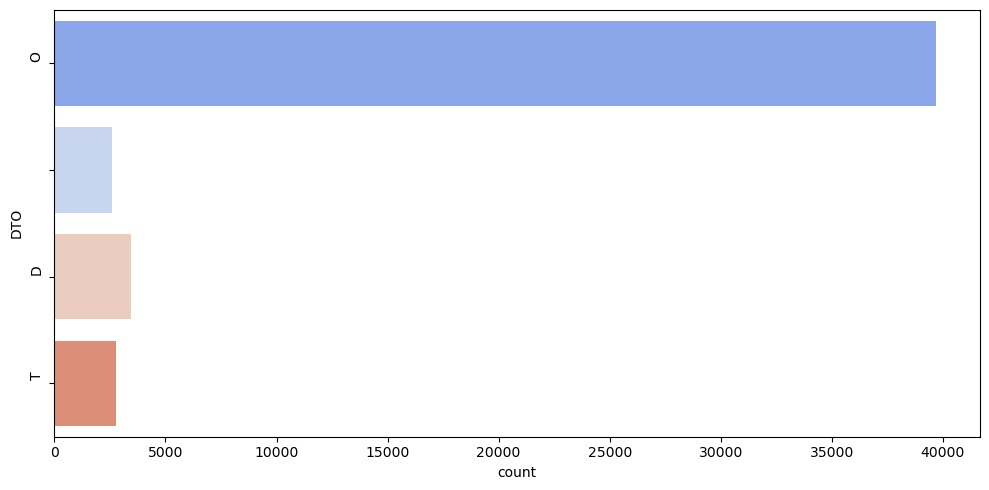

In [14]:
# visualize DTO vs count
df = pd.DataFrame(loaded, columns=["DTO"])

plt.figure(figsize=(10, 5))
ax = sns.countplot(y='DTO', data=df, palette='coolwarm')  #Use y='DTO' for vertical bars
ax.set_yticklabels(ax.get_yticklabels(), rotation=90, ha="center")  
plt.tight_layout()
plt.show()

In [15]:
opened = open("data-upgrad/test_label", 'r')
loaded = opened.readlines()
opened.close()

/var/folders/3j/f10n0hw96xdf7lpsb61w6vn80000gn/T/ipykernel_71510/3784300151.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(y='DTO', data=df2, palette='coolwarm')  # Use y='DTO' for vertical bars
/var/folders/3j/f10n0hw96xdf7lpsb61w6vn80000gn/T/ipykernel_71510/3784300151.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")


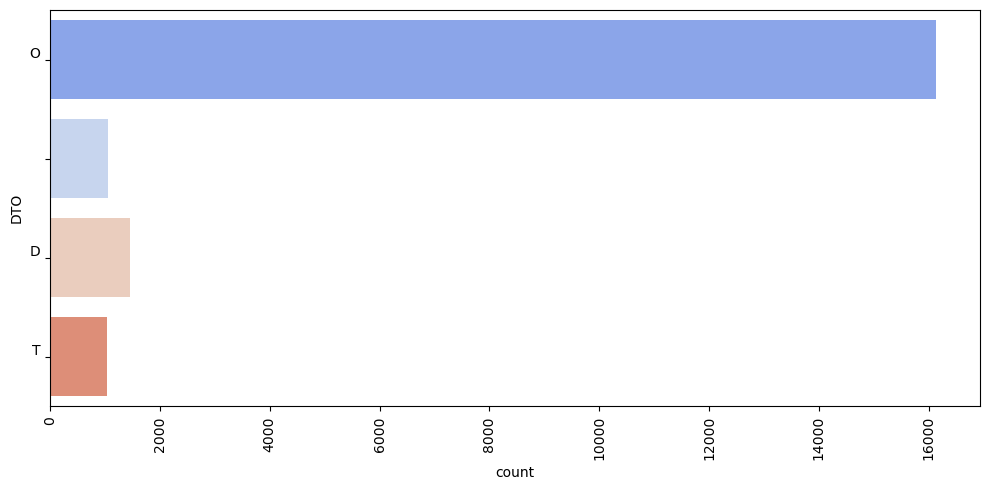

In [16]:
# visualize DTO vs count
df2 = pd.DataFrame(loaded, columns=["DTO"])

plt.figure(figsize=(10, 5))
ax = sns.countplot(y='DTO', data=df2, palette='coolwarm')  # Use y='DTO' for vertical bars
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")  
plt.tight_layout()  
plt.show()

### Printing first 5 TRAIN sentence and it's labels

In [18]:
print_sent(train_sent, train_label, count=5)

Sentence 0 : All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
sentences,All,live,births,>,or,=,23,weeks,at,the,...,",",and,practice,group,(,to,reflect,risk,status,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 1 : The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
sentences,The,total,cesarean,rate,was,14.4,%,(,344,of,...,primary,rate,was,11.4,%,(,244,of,2144,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 2 : Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
sentences,Abnormal,presentation,was,the,most,common,indication,(,25.6,%,",",88,of,344,)
label,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O


Sentence 3 : The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )


,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
sentences,The,``,corrected,'',cesarean,rate,(,maternal-fetal,medicine,and,...,primary,rate,was,9.6,%,(,190,of,1975,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 4 : Arrest of dilation was the most common indication in both `` corrected '' subgroups ( 23.4 and 24.6 % , respectively )


,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
sentences,Arrest,of,dilation,was,the,most,common,indication,in,both,...,'',subgroups,(,23.4,and,24.6,%,",",respectively,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


### Printing first 5 TEST sentence and it's labels

In [20]:
print_sent(test_sent, test_label, count=5)

Sentence 0 : Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )


,0,1,2,3,4,5,6,7,8,9,...,34,35,36,37,38,39,40,41,42,43
sentences,Furthermore,",",when,all,deliveries,were,analyzed,",",regardless,of,...,2214,;,primary,9.2,%,",",183,of,1994,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 1 : As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
sentences,As,the,ambient,temperature,increases,",",there,is,an,increase,in,insensible,fluid,loss,and,the,potential,for,dehydration
label,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O,O


Sentence 2 : The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
sentences,The,daily,high,temperature,ranged,from,71,to,104,degrees,...,ranged,from,1.7,to,24.7,cm,during,the,study,period
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 3 : There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )


,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
sentences,There,was,a,significant,correlation,between,the,2-,",",3-,...,=,0.31,",",p,&,#,60,;,0.001,)
label,O,O,O,O,O,O,O,O,O,O,...,O,O,O,O,O,O,O,O,O,O


Sentence 4 : Fluctuations in ambient temperature are inversely correlated to changes in AFI


,0,1,2,3,4,5,6,7,8,9,10
sentences,Fluctuations,in,ambient,temperature,are,inversely,correlated,to,changes,in,AFI
label,O,O,O,O,O,O,O,O,O,O,O


### Count the number of sentences in the processed train and test dataset 

In [22]:
print("No. sentences in processed train dataset is: ", len(train_sent))
print("No. sentences in processed test dataset is: ", len(test_sent))

No. sentences in processed train dataset is:  2599
No. sentences in processed test dataset is:  1056


### Count the number of lines of labels in the processed train and test dataset.

In [24]:
print("No. sentences in processed train dataset is: ", len(train_label))
print("No. sentences in processed test dataset is: ", len(test_label))

No. sentences in processed train dataset is:  2599
No. sentences in processed test dataset is:  1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 



### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [27]:
all_noun_propn = []
all_sentence = train_sent + test_sent

for sentence in all_sentence:
    doc = model(sentence)
    
    for token in doc:
        if token.pos_=="NOUN" or token.pos_ == "PROPN":
            all_noun_propn.append(token.text)

In [28]:
len(all_noun_propn)

24373

### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [30]:
from nltk import FreqDist

In [31]:
word_frequency = FreqDist(all_noun_propn)

In [32]:
pd.DataFrame(word_frequency.most_common(25), columns=["Sentence", "Count"])

,Sentence,Count
0,patients,492
1,treatment,281
2,%,247
3,cancer,200
4,therapy,175
5,study,154
6,disease,142
7,cell,140
8,lung,116
9,group,94


## Model 1 

## Defining features for CRF

In [35]:
# define the features

def getFeaturesForOneWord(sentence, pos):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), 
    'word[-3:]=' + word[-3:],     # last three characters
    'word[-2:]=' + word[-2:],     # last two characters
    'word.isupper=%s' % word.isupper(),  # word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # number
    'word.startsWithCapital=%s' % word[0].isupper(), # word starting with a capital letter
    ]

    # previous word while defining features
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
    ])
   
    else:
        features.append('BEG') # begining of sentence 

    if(pos == len(sentence)-1):
        features.append('END') # end of sentence

    return features

### Write a code/function to get the features for a sentence

In [37]:
def getFeaturesForOneSentence(sentence):
    
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

### Visualizing the input features

In [39]:
input_sentence = train_sent[1]
print(input_sentence)

features = getFeaturesForOneSentence(input_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False']

In [40]:
# 'getFeaturesForOneSentence' to get features on a single sentence
input_sentence = train_sent[1]
print(input_sentence)

features = getFeaturesForOneSentence(input_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'BEG']

### Write a code/function to get the labels of a sentence

In [42]:
def getLabelsInListForOneSentence(labels):
    return labels.split()

## Define input and target variables


### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [45]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [47]:
y_train = [getLabelsInListForOneSentence(label) for label in train_label]
y_test = [getLabelsInListForOneSentence(label) for label in test_label]

## Build the CRF Model

In [49]:
# CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)

In [50]:
repr(crf)

'CRF(max_iterations=100)'

### Tranning model

In [52]:
crf.fit(X_train, y_train)

CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [55]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [57]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9032811676283046


##Identifying Diseases and Treatments using Custom NER

### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

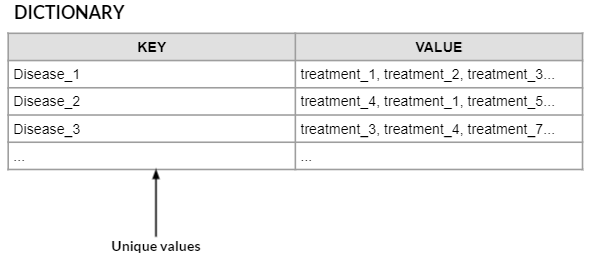

## Creating Dataframe for Disease	and Treatments

In [62]:
D_n_T_DF = pd.DataFrame([], columns=["Disease", "Treatments"])
D_n_T_DF

,Disease,Treatments


In [63]:
for i in range(len(y_pred)):

  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sent[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sent[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      D_n_T_DF = pd.concat([D_n_T_DF, pd.DataFrame([[dise, treat]], columns=D_n_T_DF.columns )])

D_n_T_DF = D_n_T_DF.set_index(np.arange(D_n_T_DF.shape[0]))
D_n_T_DF

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,unstable angina or non-Q-wave myocardial infar...,roxithromycin
2,coronary-artery disease,Antichlamydial antibiotics
3,primary pulmonary hypertension ( PPH ),fenfluramines
4,cellulitis,G-CSF therapy intravenous antibiotic treatment
...,...,...
97,temporomandibular joint arthropathy,arthroscopic treatment
98,severe secondary peritonitis,Surgical management
99,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
100,Poliomyelitis prevention,live oral poliovirus vaccines


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [65]:
search_key = 'hereditary retinoblastoma'
D_n_T_DF.loc[(D_n_T_DF.Disease == search_key), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


## Model 2
#### Adding POS tag in feature

In [67]:
# feature value for one word

def getFeaturesForOneWord(sentence, pos, pos_tags):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), 
    'word[-3:]=' + word[-3:],     # three characters
    'word[-2:]=' + word[-2:],     # two characters in end
    'word.isupper=%s' % word.isupper(),  # word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # number
    'word.startsWithCapital=%s' % word[0].isupper(), # capital letter
    'word.pos=' + pos_tags[pos] # add POS tag 
    ]
    
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1] # POS tag
    ])
    
    else:
        features.append('BEG') # begining of sentence 

    if(pos == len(sentence)-1):
        features.append('END') # end of sentence

    return features

In [68]:
# get features for a sentence
def getFeaturesForOneSentence(sentence):
    
    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []
    
    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep
    
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags) for pos in range(len(sentence_list))]

In [69]:
# getFeaturesForOneSentence to get features on a single sentence
input_sentence = train_sent[1]
print(input_sentence)

features = getFeaturesForOneSentence(input_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADJ',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=ADJ']

In [70]:
# getFeaturesForOneSentence to get features on a single sentence
input_sentence = train_sent[1]
print(input_sentence)

features = getFeaturesForOneSentence(input_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.pos=DET',
 'BEG']

In [71]:
# labels for sentence
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [72]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [74]:
y_train = [getLabelsInListForOneSentence(label) for label in train_label]
y_test = [getLabelsInListForOneSentence(label) for label in test_label]

In [75]:
# CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=100)

In [76]:
crf.fit(X_train, y_train)

CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [79]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [81]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9086787351649367


## Creating Dataframe for Disease	and Treatments

In [83]:
D_n_T_DF = pd.DataFrame([], columns=["Disease", "Treatments"])
D_n_T_DF

,Disease,Treatments


In [84]:
for i in range(len(y_pred)):

  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sent[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sent[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      D_n_T_DF = pd.concat([D_n_T_DF, pd.DataFrame([[dise, treat]], columns=D_n_T_DF.columns )])

D_n_T_DF = D_n_T_DF.set_index(np.arange(D_n_T_DF.shape[0]))
D_n_T_DF

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,myocardial infarction,"warfarin with 80 mg aspirin , or 1 mg warfarin..."
2,unstable angina,roxithromycin
3,primary pulmonary hypertension ( PPH ),fenfluramines
4,foot infection,G-CSF treatment
...,...,...
106,severe secondary peritonitis,Surgical management
107,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
108,chronic renal failure,Epoetin
109,epithelial ovarian cancer,High-dose chemotherapy


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [86]:
search_key = 'hereditary retinoblastoma'
D_n_T_DF.loc[(D_n_T_DF.Disease == search_key), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


## Model 3
#### Adding POS tag and Dependancy tag in feature

In [88]:
# feature value for one word.

def getFeaturesForOneWord(sentence, pos, pos_tags, deptags):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), 
    'word[-3:]=' + word[-3:],     # three characters
    'word[-2:]=' + word[-2:],     # two characters
    'word.isupper=%s' % word.isupper(),  # word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # number
    'word.startsWithCapital=%s' % word[0].isupper(), # capital letter
    'word.pos=' + pos_tags[pos], # POS tag
    'word.dep_=' + deptags[pos] # DEP tag
    ]

    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1], # POS tag
        'word.dep_=' + deptags[pos-1] # DEP tag
    ])
    
    else:
        features.append('BEG') # begining of sentence 

    if(pos == len(sentence)-1):
        features.append('END') # end of sentence

    return features

In [89]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    
    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []
    
    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep
    
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags, deptags) for pos in range(len(sentence_list))]

In [90]:
# getFeaturesForOneSentence to get features on a single sentence
input_sentence = train_sent[1]
print(input_sentence)

features = getFeaturesForOneSentence(input_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADJ',
 'word.dep_=amod',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=ADJ',
 'word.dep_=amod']

In [91]:
# getFeaturesForOneSentence to get features on a single sentence
input_sentence = train_sent[1]
print(input_sentence)

features = getFeaturesForOneSentence(input_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.pos=DET',
 'word.dep_=det',
 'BEG']

In [92]:
# labels for a sentence
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [93]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [95]:
y_train = [getLabelsInListForOneSentence(label) for label in train_label]
y_test = [getLabelsInListForOneSentence(label) for label in test_label]

In [96]:
# CRF model
crf = sklearn_crfsuite.CRF(max_iterations=100)

In [97]:
crf.fit(X_train, y_train)

CRF(max_iterations=100)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [100]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [102]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9076180102868305


## Creating Dataframe for Disease	and Treatments

In [104]:
D_n_T_DF = pd.DataFrame([], columns=["Disease", "Treatments"])
D_n_T_DF

,Disease,Treatments


In [105]:
for i in range(len(y_pred)):

  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sent[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sent[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      D_n_T_DF = pd.concat([D_n_T_DF, pd.DataFrame([[dise, treat]], columns=D_n_T_DF.columns )])

D_n_T_DF = D_n_T_DF.set_index(np.arange(D_n_T_DF.shape[0]))
D_n_T_DF

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,myocardial infarction,"warfarin with 80 mg aspirin , or 1 mg warfarin..."
2,unstable angina or non-Q-wave myocardial infar...,roxithromycin
3,coronary-artery disease,Antichlamydial antibiotics
4,primary pulmonary hypertension ( PPH ),fenfluramines
...,...,...
103,temporomandibular joint arthropathy,arthroscopic treatment
104,severe secondary peritonitis,Surgical management
105,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
106,chronic renal failure,Epoetin


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [107]:
search_key = 'hereditary retinoblastoma'
D_n_T_DF.loc[(D_n_T_DF.Disease == search_key), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy


## Model 4
#### max_iterations - 500

In [109]:
# feature value for one word.

def getFeaturesForOneWord(sentence, pos, pos_tags, deptags):
    word = sentence[pos]

    features = [
    'word.lower=' + word.lower(), 
    'word[-3:]=' + word[-3:],     # three characters
    'word[-2:]=' + word[-2:],     # two characters
    'word.isupper=%s' % word.isupper(),  # word in all uppercase
    'word.isdigit=%s' % word.isdigit(),  # number
    'word.startsWithCapital=%s' % word[0].isupper(), # capital letter
    'word.pos=' + pos_tags[pos], # POS tag
    'word.dep_=' + deptags[pos] # DEP tag
    ]

   
    if(pos > 0):
        prev_word = sentence[pos-1]
        features.extend([
        'prev_word.lower=' + prev_word.lower(), 
        'prev_word.isupper=%s' % prev_word.isupper(),
        'prev_word.isdigit=%s' % prev_word.isdigit(),
        'prev_word.startsWithCapital=%s' % prev_word[0].isupper(),
        'prev_word.pos=' + pos_tags[pos-1], # POS tag
        'word.dep_=' + deptags[pos-1] # DEP tag
    ])
    
    else:
        features.append('BEG') # begining of sentence 

    if(pos == len(sentence)-1):
        features.append('END') # end of sentence

    return features

In [110]:
# Function to get features for a sentence.
def getFeaturesForOneSentence(sentence):
    
    # We need to get the pos_tags to be passed to the function
    processed_sent = model(sentence)
    postags = []
    deptags = []
    
    for each_token in processed_sent:
        postags.append(each_token.pos_)
        deptags.append(each_token.dep_) # add dep
    
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos, postags, deptags) for pos in range(len(sentence_list))]

In [111]:
# getFeaturesForOneSentence to get features on a single sentence
input_sentence = train_sent[1]
print(input_sentence)

features = getFeaturesForOneSentence(input_sentence)
features[2]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=cesarean',
 'word[-3:]=ean',
 'word[-2:]=an',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=False',
 'word.pos=ADJ',
 'word.dep_=amod',
 'prev_word.lower=total',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_word.startsWithCapital=False',
 'prev_word.pos=ADJ',
 'word.dep_=amod']

In [112]:
# getFeaturesForOneSentence to get features on a single sentence
input_sentence = train_sent[1]
print(input_sentence)

features = getFeaturesForOneSentence(input_sentence)
features[0]

The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )


['word.lower=the',
 'word[-3:]=The',
 'word[-2:]=he',
 'word.isupper=False',
 'word.isdigit=False',
 'word.startsWithCapital=True',
 'word.pos=DET',
 'word.dep_=det',
 'BEG']

In [113]:
# labels for a sentence
def getLabelsInListForOneSentence(labels):
    return labels.split()

In [114]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

### Define the labels as the target variable for test and the train dataset

In [116]:
y_train = [getLabelsInListForOneSentence(label) for label in train_label]
y_test = [getLabelsInListForOneSentence(label) for label in test_label]

In [117]:
# Build the CRF model.
crf = sklearn_crfsuite.CRF(max_iterations=500)

In [118]:
crf.fit(X_train, y_train)

CRF(max_iterations=500)

## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [121]:
y_pred = crf.predict(X_test)

### Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [123]:
f1_score = metrics.flat_f1_score(y_test, y_pred, average='weighted')
print("F1 score:", f1_score)

F1 score: 0.9106955156007338


## Creating Dataframe for Disease	and Treatments

In [125]:
D_n_T_DF = pd.DataFrame([], columns=["Disease", "Treatments"])
D_n_T_DF

,Disease,Treatments


In [126]:
for i in range(len(y_pred)):

  p_val = y_pred[i]
  dise = ""
  treat = ""

  DTO = set(p_val)
  if "D" in DTO and "T" in DTO:

    for j in range(len(p_val)):
      if p_val[j] == 'D':
        dise += test_sent[i].split()[j] + " "
      elif p_val[j] == 'T':
        treat += test_sent[i].split()[j] + " "

    dise = dise.strip()
    treat = treat.strip()

    present = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Disease"]]
    if present.size:
      treatment_df = D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]]
      treatment = treatment_df.values.tolist()
      treatment.extend([treat])
      D_n_T_DF.loc[(D_n_T_DF.Disease == dise), ["Treatments"]] = [[treatment]]

    else:
      D_n_T_DF = pd.concat([D_n_T_DF, pd.DataFrame([[dise, treat]], columns=D_n_T_DF.columns )])

D_n_T_DF = D_n_T_DF.set_index(np.arange(D_n_T_DF.shape[0]))
D_n_T_DF

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
1,epilepsy,Methylphenidate
2,unstable angina or non-Q-wave myocardial infar...,roxithromycin
3,coronary-artery disease,Antichlamydial antibiotics
4,primary pulmonary hypertension ( PPH ),fenfluramines
...,...,...
103,temporomandibular joint arthropathy,arthroscopic treatment
104,severe secondary peritonitis,Surgical management
105,hepatic metastases from colorectal cancer,Hepatic arterial infusion of chemotherapy afte...
106,epithelial ovarian cancer,High-dose chemotherapy


#### improvement in accuracy => 90.7 to 91.06

### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [129]:
search_key = 'hereditary retinoblastoma'
D_n_T_DF.loc[(D_n_T_DF.Disease == search_key), ["Disease", "Treatments"]]

,Disease,Treatments
0,hereditary retinoblastoma,radiotherapy
